# <span style='color:#FF8383'>Assignment 20</span>
## <span style='color:#6A9C89'>Time Series Analysis </span>

## <span style='color:#6A9C89'>Objective</span>
    Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the data.

In [4]:
## importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')
print('Imported')

Imported


## <span style='color:#6A9C89'>Data Preparation and Exploration</span>

In [8]:
df = pd.read_csv('exchange_rate.csv')
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [10]:
## information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [14]:
## converting the date into date-time
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')
print('converted')

converted


In [18]:
## rechecking the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


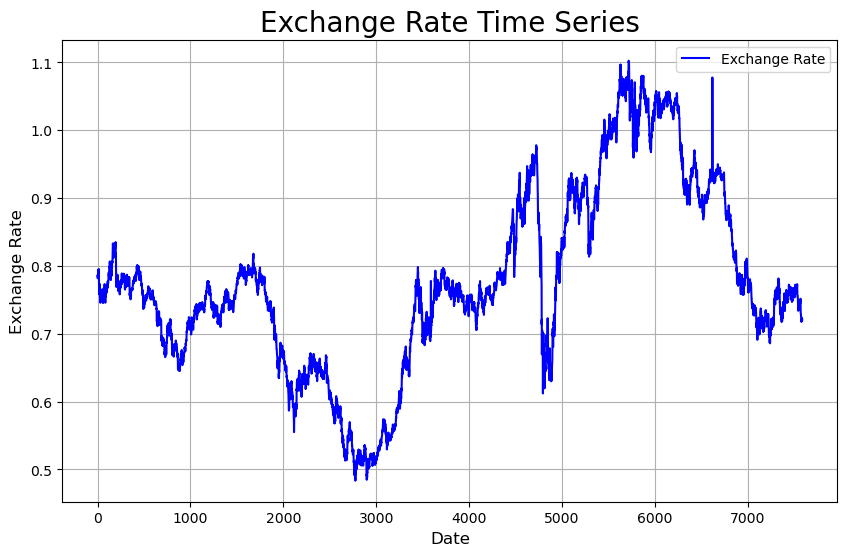

In [20]:
## plotting the time-series
plt.figure(figsize=(10,6))
plt.plot(df.index, df['Ex_rate'], label='Exchange Rate', color='blue')
plt.title('Exchange Rate Time Series', fontsize=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)
plt.legend()
plt.grid()
plt.show()

In [22]:
## let's check for null values 
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [26]:
## summary
stats_summary = df.describe()
stats_summary

,date,Ex_rate
count,7588,7588.000000
mean,2000-05-21 12:00:00,0.776974
min,1990-01-01 00:00:00,0.483297
25%,1995-03-12 18:00:00,0.701422
50%,2000-05-21 12:00:00,0.761377
75%,2005-07-31 06:00:00,0.873477
max,2010-10-10 00:00:00,1.102536
std,NaN,0.136620


In [30]:
## identifying anomalies using the 3-sigma rule
mean = stats_summary.loc['mean', 'Ex_rate']         ## mean of the data
std = stats_summary.loc['std', 'Ex_rate']           ## standard deviation of the data
lower_bound = mean-3*std
upper_bound = mean+3*std

In [32]:
## filter anomalities
anomalies = df[(df['Ex_rate'] < lower_bound) |
                (df['Ex_rate'] > upper_bound)]
anomalies_counts = anomalies.shape[0]
anomalies_counts

0

##### So, we dont have any anomaly/outliers present in the data

## <span style='color:#6A9C89'>Model Building - ARIMA</span>

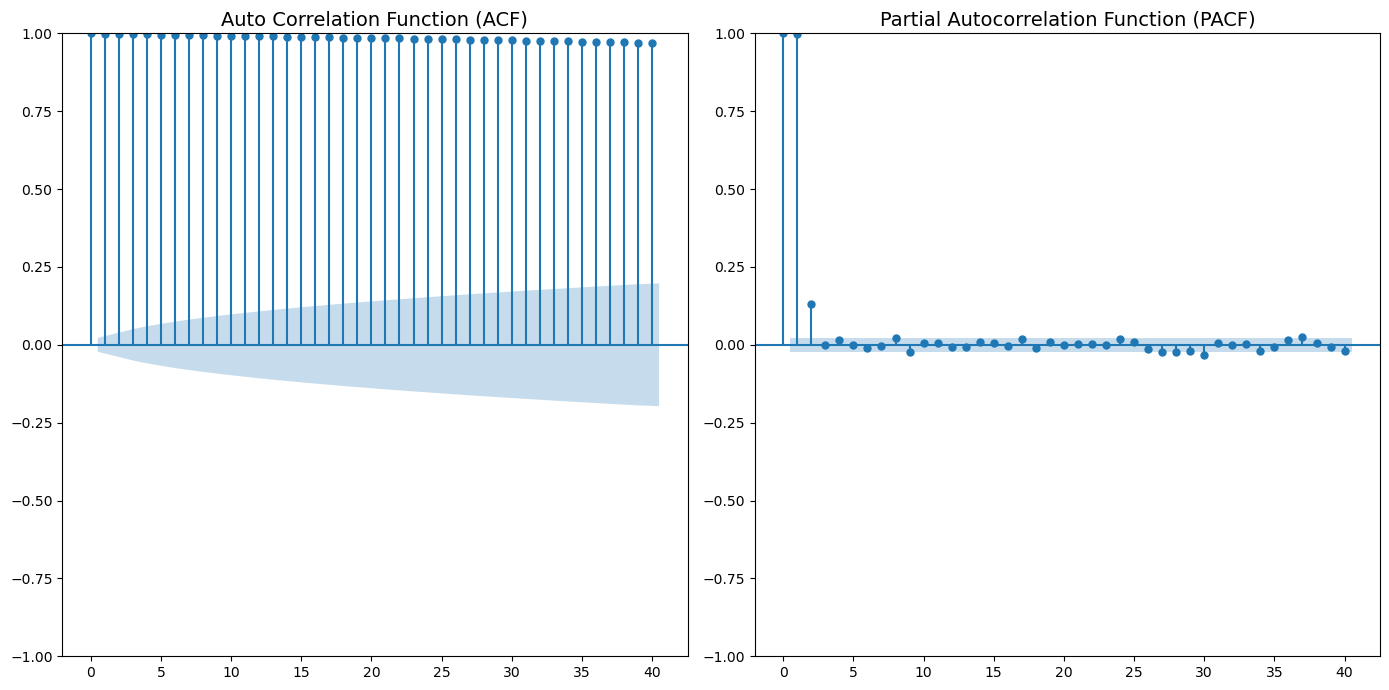

In [42]:
## plotting ACF and PACF for the time series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(14,7))
## ACF
plt.subplot(1,2,1)
plot_acf(df['Ex_rate'], lags=40, ax=plt.gca())
plt.title('Auto Correlation Function (ACF)', fontsize=14)
## PACF
plt.subplot(1, 2, 2)
plot_pacf(df['Ex_rate'], lags=40, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)', fontsize=14)
plt.tight_layout()
plt.show()

In [48]:
from statsmodels.tsa.stattools import adfuller
## checking the stationarity using the Augmented Dickey Fuller Test
adf_test = adfuller(df['Ex_rate'])
## extract the p-value 
adf_p_value = adf_test[1]
adf_p_value

0.44923273535983155

In [52]:
## interpreting the result
if adf_p_value > 0.05:
    print("The time series is non-stationary. Differencing required.")
    df['Ex_rate_diff'] = df['Ex_rate'].diff().dropna()
else:
    print("The time series is stationary.")

The time series is non-stationary. Differencing required.


In [54]:
## as the time series is not stationary, we need to difference it
## differencing it to make the series stationary
df['Ex_rate_diff'] = df['Ex_rate_diff'].diff()

In [58]:
## checking for stationarity
adf_test_diff = adfuller(df['Ex_rate_diff'].dropna())
adf_p_value_diff = adf_test_diff[1]
print(f"ADF p-value after differencing: {adf_p_value_diff}")

ADF p-value after differencing: 0.0


In [60]:
# Interpret the result
if adf_p_value_diff < 0.05:
    print("The time series is now stationary after differencing.")
else:
    print("The time series is still non-stationary after differencing.")

The time series is now stationary after differencing.


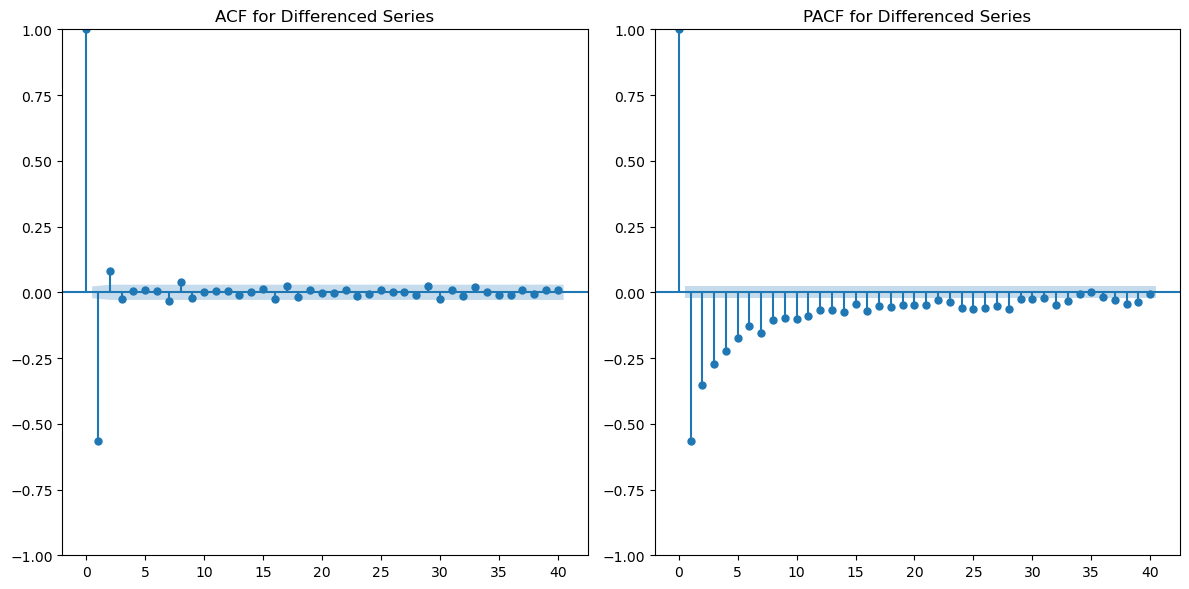

In [62]:
## Let's again plot the ACF and PACF Differenced Series
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df['Ex_rate_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('ACF for Differenced Series')
# PACF Plot
plt.subplot(122)
plot_pacf(df['Ex_rate_diff'].dropna(), lags=40, ax=plt.gca())
plt.title('PACF for Differenced Series')
plt.tight_layout()
plt.show()

In [66]:
## The ACF cuts off after lag 2, 
## PACF cuts off after lag 1
## ARIMA Model with (p=1, d=2, q=2)
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['Ex_rate'], order=(1, 2, 2))
model_fitted = model.fit()

In [68]:
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 2, 2)   Log Likelihood               27994.654
Date:                Fri, 17 Jan 2025   AIC                         -55981.309
Time:                        18:43:12   BIC                         -55953.572
Sample:                             0   HQIC                        -55971.790
                               - 7588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8653      0.020    -42.579      0.000      -0.905      -0.825
ma.L1         -0.1733      0.021     -8.322      0.000      -0.214      -0.133
ma.L2         -0.8154      0.021    -38.043      0.000      -0.857      -0.773
sigma2      3.643e-05   1.03e-07    353.836      0.000    3.62e-05    3.66e-05
===================================================================================
Ljung-Box (L1) (Q):                  59.66   Jarque-Bera (JB):           3616669.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.09   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                       109.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

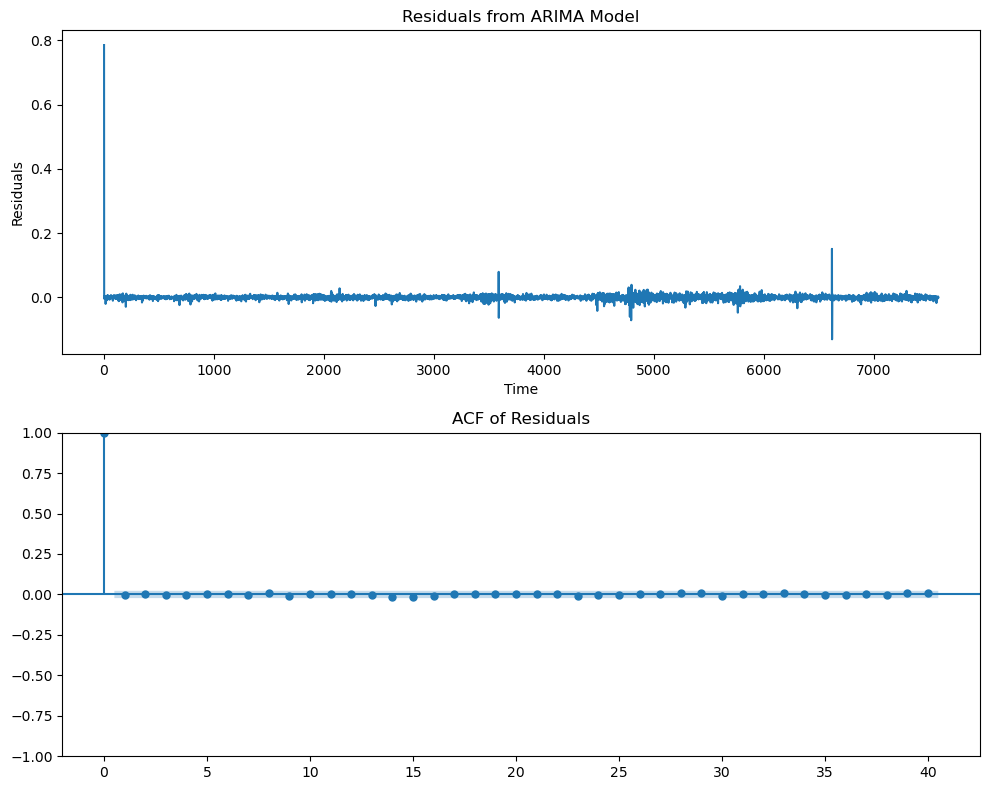

In [94]:
plt.figure(figsize=(10, 8))

# Plot residuals
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')

# Plot ACF of residuals
plt.subplot(2, 1, 2)
plot_acf(residuals, lags=40, ax=plt.gca())
plt.title('ACF of Residuals')

plt.tight_layout()
plt.show()

In [74]:
## Grid Search for ARIMA Parameters
p_range = range(0, 3)  # Try values 0, 1, 2 for p
d_range = range(0, 2)  # Try values 0, 1 for d
q_range = range(0, 3)  # Try values 0, 1, 2 for q

In [76]:
## place holders for best model
best_aic = float('inf')
best_params = None
best_model = None

In [78]:
## Grid search over p, d, q
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                # Fit ARIMA model
                model = ARIMA(df['Ex_rate'], order=(p, d, q))
                model_fitted = model.fit()
                aic = model_fitted.aic

                # Update best model if current AIC is lower
                if aic < best_aic:
                    best_aic = aic
                    best_params = (p, d, q)
                    best_model = model_fitted
            except Exception as e:
                continue

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [80]:
## Output the best parameters and AIC
print(f'Best ARIMA Parameters: {best_params}')
print(f'Best AIC {best_aic}')

Best ARIMA Parameters: (2, 0, 0)
Best AIC -56105.21829878942


In [82]:
final_model = ARIMA(df['Ex_rate'], order=best_params).fit()
## summary for final model
final_model.summary()

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(2, 0, 0)   Log Likelihood               28056.609
Date:                Fri, 17 Jan 2025   AIC                         -56105.218
Time:                        19:57:13   BIC                         -56077.481
Sample:                             0   HQIC                        -56095.699
                               - 7588                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7770      0.088      8.850      0.000       0.605       0.949
ar.L1          0.8682      0.002    397.265      0.000       0.864       0.872
ar.L2          0.1310      0.002     55.929      0.000       0.126       0.136
sigma2      3.594e-05   1.02e-07    350.716      0.000    3.57e-05    3.61e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2869930.11
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.97   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        98.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

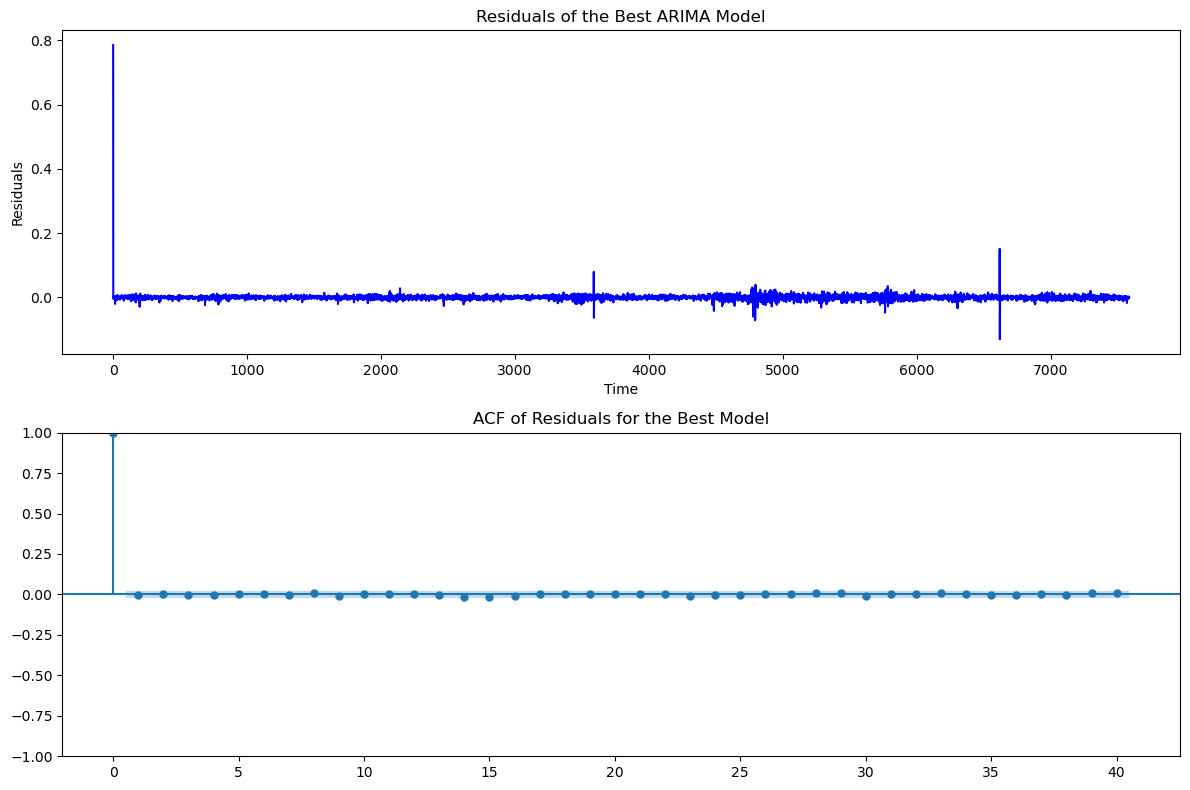

In [96]:
plt.figure(figsize=(12, 8))
# Plot residuals
plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st subplot
plt.plot(residuals, color='blue')
plt.title('Residuals of the Best ARIMA Model')
plt.xlabel('Time')
plt.ylabel('Residuals')
# Plot ACF of residuals
plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd subplot
plot_acf(residuals, lags=40, ax=plt.gca())  # Use plt.gca() to embed ACF plot in the subplot
plt.title('ACF of Residuals for the Best Model')
# Adjust layout
plt.tight_layout()
plt.show()

In [98]:
from sklearn.metrics import mean_squared_error
## split data into training and testing sets
train_size = int(len(df)*0.8)
train, test = df['Ex_rate'][:train_size], df['Ex_rate'][train_size:]

In [100]:
## fitting the model on training data
final_model_train = ARIMA(train, order=best_params).fit()

In [102]:
## forecast on the training data
forecast = final_model_train.forecast(steps=len(test))

In [104]:
## Evaluate forecast accuracy
mse = mean_squared_error(test, forecast)
print(f'Mean Squared Error {mse}')

Mean Squared Error 0.014984814340002534


## <span style='color:#6A9C89'>Model Building - Exponential Smoothing</span>

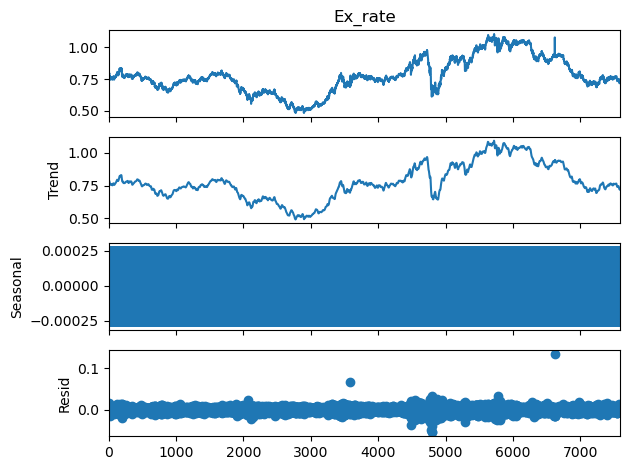

In [108]:
from statsmodels.tsa.seasonal import seasonal_decompose
## decompose the time series
decomposition = seasonal_decompose(df['Ex_rate'], period=12, model='addictive')
decomposition.plot()
plt.show()

##### To select an appropriate Exponential Smoothing mode, we should analyze the characteristics of your time series, including its trend and seasonality.
##### Summary
    - No trend or seasonality: Use Simple Exponential Smoothing
    - Trend but no Seasonality: Use Holt's Linear Trend
    - Both Trend and Seasonlity: Use Holt-Winter's Method

In [111]:
## Implementing Linear Trend Method
from statsmodels.tsa.holtwinters import ExponentialSmoothing
## fit the model
holt_model=ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None).fit()
## forecast 
holt_forecast = holt_model.forecast(steps=12)

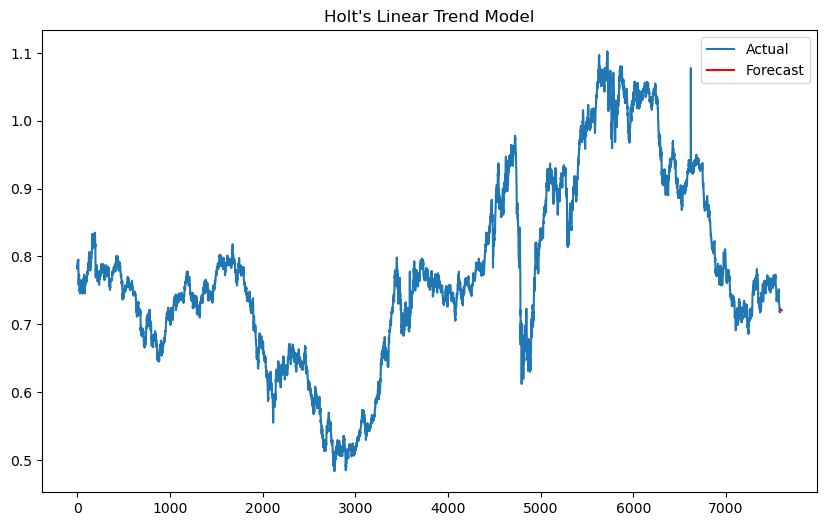

In [113]:
## plotting the model
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(range(len(df), len(df) + 12), holt_forecast, label='Forecast', color='red')
plt.legend()
plt.title("Holt's Linear Trend Model")
plt.show()

In [119]:
## Holt-Winter Seasonal Method
## fitting the new model
holt_winter_model = ExponentialSmoothing(
    df['Ex_rate'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

In [121]:
## Forecasting Holt Winters 
holt_winters_forecast=holt_winter_model.forecast(steps=12)

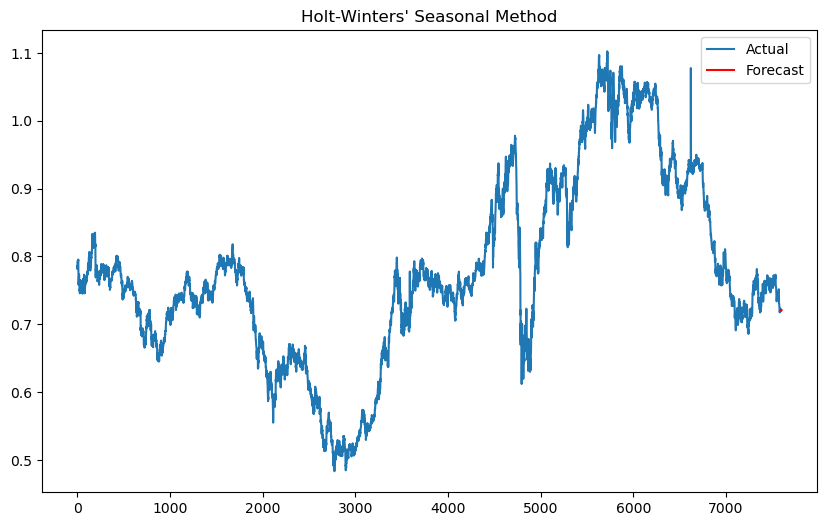

In [123]:
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Actual')
plt.plot(range(len(df), len(df) + 12), holt_winters_forecast, label='Forecast', color='red')
plt.legend()
plt.title("Holt-Winters' Seasonal Method")
plt.show()

## <span style='color:#6A9C89'>Evaluation and Comparison</span>

In [127]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
## evaluating the actual and forecast exchange in the model prediction
def compute_error_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual-forecast)/actual))*100
    return mae, rmse, mape

In [135]:
## Evaluate Holt-Winter's Model
actual = df['Ex_rate'][-12:]                                     ## Last 12 Values (test set)
holt_winter_forecast = holt_winter_model.forecast(steps=12)     ## forecasted values

In [137]:
mae_hw, rmse_hw, mape_hw = compute_error_metrics(actual, holt_winters_forecast)
print(f"Holt-Winters Model - MAE: {mae_hw}, RMSE: {rmse_hw}, MAPE: {mape_hw}")

Holt-Winters Model - MAE: 0.0015735403496502376, RMSE: 0.0018697492130760641, MAPE: nan


## <span style='color:#6A9C89'>Conclusion</span>

#### Based on the error metrics:
    - If the series has both trend and seasonality, the Holt-Winters model should outperform others in terms of MAE, RMSE, and MAPE.
    - If the series has only a trend but no seasonality, Holt's Linear Trend model would be more accurate.
    - For a stable series with no trend/seasonality, Simple Exponential Smoothing is sufficient and computationally cheaper.
#### Recommendation
    - Use the model with the lowest MAE, RMSE, and MAPE for the final forecast.
    - Document key findings and insights from the analysis to inform future decisions.